### 랜덤포레스트 모델 만들기

In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#### 1. 데이터 준비하기

Text(0, 0.5, 'X2')

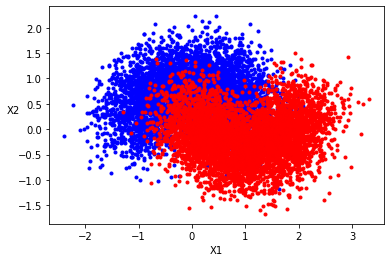

In [2]:
X, y = make_moons(n_samples = 10000, noise=0.4, random_state=42)

# X[:, 0] # X1 특성
# X[:, 1] # X2 특성

plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'b.') # 0번 클래스 blue
plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'r.') # 1번 클래스 red
plt.xlabel("X1")
plt.ylabel("X2", rotation=0)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 2. 결정 트리 모델 학습하기(기본 파라미터) 
- 81.45% 정도의 정확도

In [4]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8145

#### 3. 결정트리 모델에 최적의 하이퍼 파라미터를 탐색
- 'max_leaf_nodes': 17 
- 86.95% 의 정확도 (기본 모델보다는 성능이 5.5% 증가)

In [6]:
len(list(range(2, 100)))

98

In [7]:
from sklearn.model_selection import GridSearchCV
# 후보가 될 파라미터의 리스트
param_grid = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]} # 98*3


grid_search = GridSearchCV(tree_clf, param_grid, scoring="accuracy", cv=3 ) # 98*3*3
grid_search.fit(X_train, y_train) # 8000개의 훈련 데이터

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             scoring='accuracy')

In [8]:
grid_search.best_params_

{'max_leaf_nodes': 17, 'min_samples_split': 2}

In [9]:
grid_search.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=17, random_state=42)

In [10]:
cvres = grid_search.cv_results_

In [ ]:
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

In [12]:
best_tree_clf = grid_search.best_estimator_
y_pred = best_tree_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8695

#### 4. 랜덤포레스트 모델 만들기(결정트리의 앙상블 학습)

- 훈련 데이터 세트를 1000세트 생성, 1000개의 트리모델 준비
- 각 모델(best_tree_clf)은 무작위 샘플링된 100개의 데이터로 학습

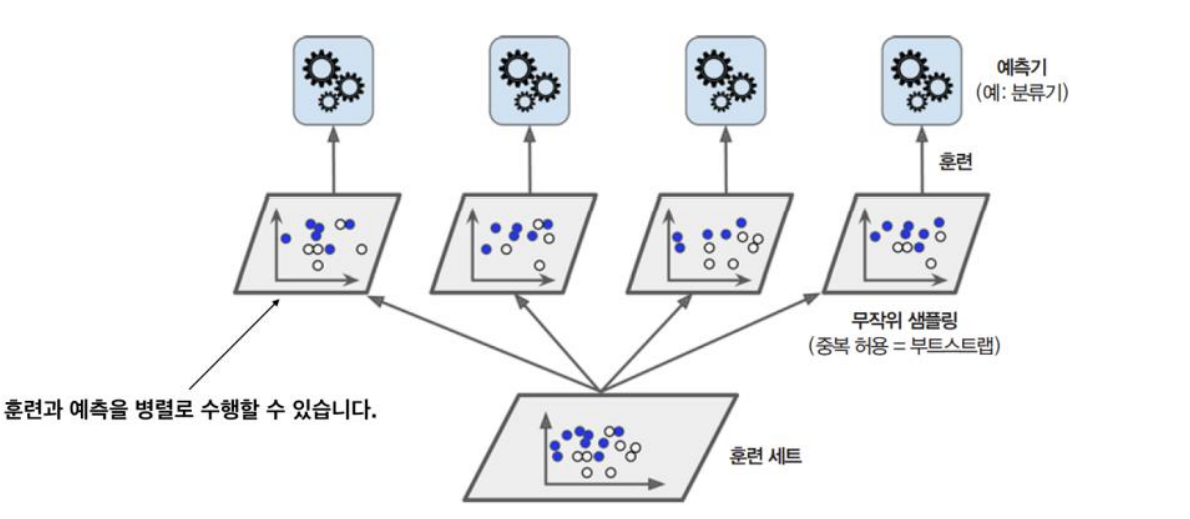

In [ ]:
from IPython.display import Image
Image('./images/img4.png')

In [14]:
from sklearn.model_selection import ShuffleSplit
n_trees = 1000
n_samples = 100
mini_sets = []

split = ShuffleSplit(n_splits = n_trees, test_size = len(X_train) - n_samples, random_state=42)
for mini_train_index, mini_test_index in split.split(X_train): # 8000개의 데이터에서 100개씩 샘플링
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

In [15]:
len(mini_sets)

1000

In [16]:
mini_sets[0][0].shape, mini_sets[0][1].shape # 1000개의 데이터셋중 첫번째 데이터의 특성과 정답

((100, 2), (100,))

In [ ]:
X_train.shape, X_test.shape

((8000, 2), (2000, 2))

In [ ]:
# 1000개의 트리 모델이 각각 100개의 작은 데이터로 학습을 한뒤
# 테스트 데이터(X_test)로 예측을 했을 때
# 개별 모델들의 평균값이 80.54 % 
# 개별 모델은 10000개로 학습했을때 보다는 안좋은 결과

In [ ]:
import numpy as np

In [ ]:
from sklearn.base import clone

accuracy_scores = []
forest = [clone(best_tree_clf) for _ in range(n_trees)]

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets): # 1000개의 모델과 1000개의 데이터셋
    tree.fit(X_mini_train, y_mini_train) # 100개의 샘플링 데이터로 훈련
    y_pred = tree.predict(X_test) # 1000개의 예측
    accuracy_scores.append(accuracy_score(y_test, y_pred)) # 1000개의 정확도

np.mean(accuracy_scores)    

0.8054499999999999

In [ ]:
Y_pred = np.empty((n_trees, len(X_test)), dtype=np.uint8)
Y_pred.shape

(1000, 2000)

In [ ]:
for tree_index, tree in enumerate(forest): # 1000개의 모델이 1000번의 예측
    y_pred = tree.predict(X_test) # 테스트 데이터 2000개의 예측
    Y_pred[tree_index] = y_pred

In [ ]:
Y_pred

array([[0, 1, 0, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 1],
       ...,
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
# scipy mode() 함수 : 최다 빈도수 값을 반환

In [ ]:
from scipy.stats import mode
y_pred_major_votes, n_votes = mode(Y_pred, axis=0)

In [ ]:
y_pred_major_votes # 최종 예측 결과로 사용하자

array([[1, 1, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
y_test.shape, y_pred_major_votes.shape

((2000,), (1, 2000))

In [ ]:
# 개별 학습기 1000개의 정확도 평균은 80.54% 
# 최다빈도수 투표를 통해 예측한 결과로 성능 측정했을 때 87.2%
# 기반모델(결정트리)로 예측했을 때의 결과 86.95% 보다도 살짝 더 나은 성능

In [ ]:
accuracy_score(y_test, y_pred_major_votes.reshape(2000,))

0.872